# Проект "Прведение A/B-теста"

Я аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

1. [Импорт данных](#start)
2. [Предобработка данных](#preprocessing)
3. [Часть 1. Приоритизация гипотез](#part_1)
4. [Часть 2. Анализ A/B-теста](#part_2)
  * Задача №1. [Построю график кумулятивной выручки по группам.](#task_1)
  * Задача №2. [Построю график кумулятивного среднего чека по группам.](#task_2)
  * Задача №3. [Построю график относительного изменения кумулятивного среднего чека группы B к группе A.](#task_3)
  * Задача №4. [Построю график кумулятивной конверсии по группам.](#task_4)
  * Задача №5. [Построю график относительного изменения кумулятивной конверсии группы B к группе A.](#task_5)
  * Задача №6. [Построю точечный график количества заказов по пользователям. ](#task_6)
  * Задача №7. [Посчитаю 95-й и 99-й перцентили количества заказов на пользователя.](#task_7)
  * Задача №8. [Построю точечный график стоимостей заказов. ](#task_8)
  * Задача №9. [Посчитаю 95-й и 99-й перцентили количества заказов на пользователя.](#task_9)
  * Задача №10. [Посчитаю статистическую значимость различий в конверсии между группами по «сырым» данным.](#task_10)
  * Задача №11. [Посчитаю статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.](#task_11)
  * Задача №12. [Посчитаю  статистическую значимость различий в конверсии между группами по «очищенным» данным.](#task_12)
  * Задача №13. [Посчитаю статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. ](#task_13)
  * Задача №14. [Применю решение по результатам теста и объявлю его.](#task_14)

## Импорт данных <a id="start"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats

In [2]:
try:
    hypothesis = pd.read_csv('/Users/Lenovo/Desktop/ЯП/Проекты/Проект 6 АБ-тесты/hypothesis.csv')
    orders = pd.read_csv('/Users/Lenovo/Desktop/ЯП/Проекты/Проект 6 АБ-тесты/orders.csv')
    visitors = pd.read_csv('/Users/Lenovo/Desktop/ЯП/Проекты/Проект 6 АБ-тесты/visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv') 
    orders = pd.read_csv('/datasets/orders.csv') 
    visitors = pd.read_csv('/datasets/visitors.csv') 

Так как работаю локально воспользовался методом try/except, взгляну на данные

In [3]:
hypothesis.info()
hypothesis.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


Сданными все впорядке, смущают только что названия столбцов с большой буквы

In [4]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


В этой таблице нужно поработать в первую очередь с датами, перевести их нужный тип

In [5]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


тут тоже даты нужно перевести в нужный тип

## Предобработка данных <a id="preprocessing"></a>

Подготовлю данные для дальнейшей работы, исправлю в них выявленные ранее шероховатости

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [7]:
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [8]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Пропусков нет, проверю наличие дубликатов.

In [9]:
print(orders.duplicated().value_counts())
print(visitors.duplicated().value_counts())

False    1197
dtype: int64
False    62
dtype: int64


In [10]:
group_a = orders[orders['group'] == 'A']['visitorId']
print('Кол-во пользвателей в группе А',group_a.value_counts().shape)
group_b = orders[orders['group'] == 'B']['visitorId']
print('Кол-во пользвателей в группе B', group_b.value_counts().shape)
print('Кол-во дубликотов в группах', group_a[group_a.isin(group_b)].shape)

Кол-во пользвателей в группе А (503,)
Кол-во пользвателей в группе B (586,)
Кол-во дубликотов в группах (89,)


Удалю дубликаты

In [11]:
duplicates = group_a[group_a.isin(group_b)].tolist()
orders= orders.query('visitorId != @duplicates')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1016 non-null int64
visitorId        1016 non-null int64
date             1016 non-null datetime64[ns]
revenue          1016 non-null int64
group            1016 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


Данные подготовлены к тетсированию, удалены пользователи которые попадали в обе группы, пропусков нет.

## Часть 1. Приоритизация гипотез. <a id="part_1"></a>

Найду 2 фреймворка **ACE** и **RICE** для приоритизаций гипотез.

In [12]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

cm = sns.light_palette("yellow", as_cmap=True)
hypothesis[['hypothesis','ICE','RICE']].style.background_gradient(cmap=cm)

,hypothesis,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3,40
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7,56
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1,9
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1,3
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3,4
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8,40
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,112
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.2


По фрейморку **ACE** наиболее перспективные гипотизы:
- Запустить акцию, дающую скидку на товар в день рождения
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

По фрейморку **RICE** наибелле перспективные гипотизы:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

После применения фрейворка **RICE** я получил приоритезацию гипотиз учитывающую не только силу гипотез но и число пользователей на которых изменения могут повлиять, это показатель `reach`, так как мы его умножали он в свою очередь и изменил так чущественно приоритезацию, поэтому получу окончательную таблицу проранжированную по **RICH**

In [13]:
rice_ice = hypothesis.sort_values('RICE', ascending = False)
cm = sns.light_palette("yellow", as_cmap=True)
rice_ice[['hypothesis','ICE','RICE']].style.background_gradient(cmap=cm)

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1,3


На основании полученной таблицы можно выделить фаворита из доступных теорий:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок


## Часть 2. Анализ A/B-теста. <a id="part_2"></a>

#### Задача №1. Построю график кумулятивной выручки по группам. <a id="task_1"></a>

In [14]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [15]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                    orders['group'] == x['group'])].agg({
                                                                    'date' : 'max',
                                                                    'group' : 'max',
                                                                    'visitorId' : 'nunique',
                                                                    'transactionId' : 'nunique',
                                                                    'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                      visitors['group'] == x['group'])].agg({
                                                                        'date' : 'max', 
                                                                        'group' : 'max', 
                                                                        'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulativeData.head(5)) 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,19,23,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,36,42,234381,1338
3,2019-08-02,B,39,40,221801,1294
4,2019-08-03,A,60,66,346854,1845


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


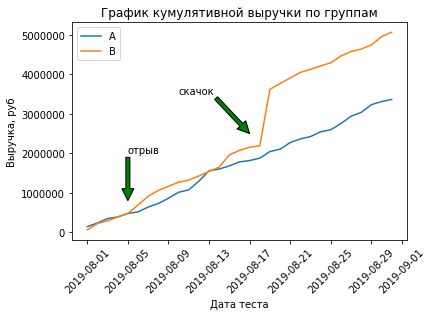

In [16]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=45)
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата теста')
plt.ylabel('Выручка, руб')
plt.legend() 
plt.annotate('скачок', xy=('2019-08-17', 2500000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g'))
plt.show()

Выручка почти равномерно увеличивается до середины теста а после в группе **B** резкий рост, это может быть сигналом об увеличении кол-ва заказов или о появлении очень дорогих заказов в выборке. Такие выбросы можно проанализировать в дальнейшем.

#### Задача №2. Построю график кумулятивного среднего чека по группам. <a id="task_2"></a>

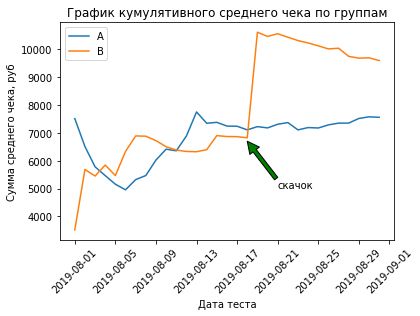

In [17]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата теста')
plt.ylabel('Сумма среднего чека, руб')
plt.annotate('скачок', xy=('2019-08-18', 6700), xytext=('2019-08-21', 5000),
          arrowprops=dict(facecolor='g'))
plt.legend()
plt.show()

Средний чек у группы **В** в середине теста резко увеличивается,  а после постпенно падает, у группы **А** к середине теста график стабилизируется а к концу начинает расти. Это еще раз говорит, что возможно в группу **А** в середине теста попали крупные заказы.

#### Задача №3. Построю график относительного изменения кумулятивного среднего чека группы B к группе A.  <a id="task_3"></a>

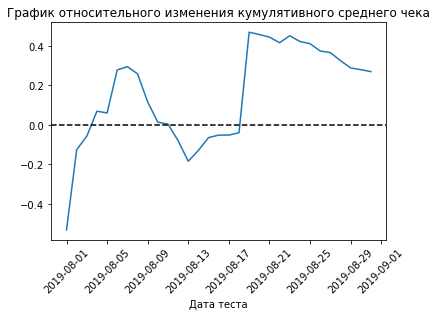

In [18]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивного среднего чека')
plt.xlabel('Дата теста')
plt.show()

В точках в середине график различия между сегментами резко скачет. возможно в середине есть выбросы!

#### Задача №4. Построю график кумулятивной конверсии по группам. <a id="task_4"></a>

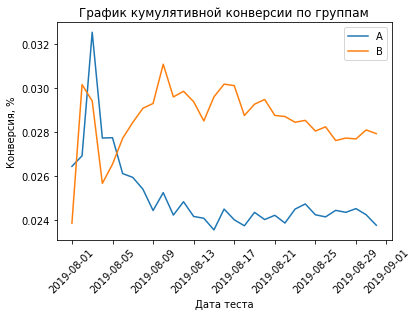

In [19]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата теста')
plt.ylabel('Конверсия, %')
plt.show()

Графики по группа сильно различаются, причина возможна снова в выбрасах группы **B**.

#### Задача №5 Построю график относительного изменения кумулятивной конверсии группы B к группе A. <a id="task_5"></a>

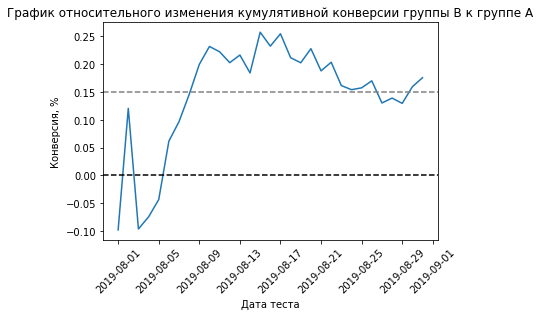

In [20]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', 
                                                                           right_on='date', 
                                                                           how='left', 
                                                                           suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата теста')
plt.ylabel('Конверсия, %')
plt.show()

В начале теста изменение кумулятивной конверсии колеблется, но к середину теста группа **В** вырывается  вперед, а к концу теста начинает падать, но в самом конце снова начинает рости.

В итоге можно прийти к выводу что отношение конверсии ещё не установилось, и делать какие-либо выводы по результатам теста пока рано, а сначало стоит проанализировать аномалии, возможно, они изменят картину.

#### Задача №6 Построю точечный график количества заказов по пользователям.  <a id="task_6"></a>

Сгрупирую данные по пользвателю и количеству заказов

In [21]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


In [22]:
ordersByUsers = orders.groupby('visitorId').agg({'transactionId': 'nunique'}).reset_index()

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(5)) 

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3


А теперь построю по этим данным график

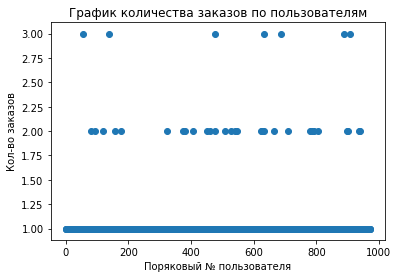

In [23]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.xlabel('Поряковый № пользователя')
plt.ylabel('Кол-во заказов')
plt.title('График количества заказов по пользователям')
plt.show()

Замечаю что есть выбросы с кол-вом заказов 3 шт., Нужно проверить с каким кол-вом заказов пользователи попадают в 95-й и 99-й прецентиль.

#### Задача №7 Посчитаю 95-й и 99-й перцентили количества заказов на пользователя. Выберу границу для определения аномальных пользователей. <a id="task_7"></a>

In [24]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Не более 5% пользователей оформляли больше чем 1  заказов. И 1% пользователей заказывали более 2 раз.

Основываясь на график и полученные процентили думаю что разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов. 

#### Задача №8 Построю точечный график стоимостей заказов.  <a id="task_8"></a>

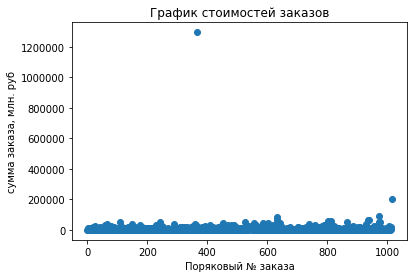

In [25]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.xlabel('Поряковый № заказа')
plt.ylabel('сумма заказа, млн. руб')
plt.title('График стоимостей заказов')
plt.show()

На точечной диаграмме четко вижу 2 выброса с заказами суммой 1.2 млн руб и 200 тыс. руб, их следуюет убрать из данных но перед удалением посмотрю попадают ли они в 95-й и 99-й процентиль.

#### Задача №9 Посчитаю 95-й и 99-й перцентили количества заказов на пользователя. <a id="task_9"></a>

In [26]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более 5% заказов дороже 26785 рублей и не более 1% дороже 53904 рублей, думаю логично взять за нижнюю сумму заказа значение 30000 руб.

#### Задача №10 Посчитаю статистическую значимость различий в конверсии между группами по «сырым» данным. <a id="task_10"></a>

Для начала получу и добавлю в одну таблицу следующие параметры:
- количество пользователей в выбранную дату по каждой группе, (**visitorsPerDate**)
- количество пользователей до выбранной даты включительно по каждой группе, (**visitorsCummulative**)
- количество заказов в выбранную дату по каждой группе, (**ordersPerDate**)
- суммарное число заказов до выбранной даты включительно по каждой группе, (**ordersCummulative**)
- суммарная выручка в выбранную дату по каждой группе,(**revenuePerDate**)
- суммарная выручка до выбранной даты включительно по каждой группе, (**revenueCummulative**)

In [27]:
#получу кол-во пользователей в выбранную дату по каждой группе
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']


#получу кол-во пользователей ДО выбранной даты включительно по каждой группе
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
                                            .agg({'date': 'max', 'visitorsPerDateA': 'sum'}),  axis=1)

visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                                            .agg({'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1)

visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


#получу кол-во заказов и суммарную выручку в выбранную дату по каждой группе
ordersADaily = (orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': 'nunique', 'revenue': 'sum'}))

ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = (orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId':'nunique', 'revenue': 'sum'}))

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']


#получу кол-во заказов и суммарную выручку ДО выбранной даты включительно по каждой группе
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]
                                        .agg({'date': 'max', 
                                              'ordersPerDateA': 'sum', 
                                              'revenuePerDateA': 'sum'}), axis=1).sort_values(by=['date'])

ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
                                        .agg({'date': 'max', 
                                              'ordersPerDateB': 'sum', 
                                              'revenuePerDateB': 'sum'}), axis=1).sort_values(by=['date'])

ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

#мержим все вместе
data = (
    ordersADaily.merge( ordersBDaily, left_on='date', right_on='date', how='left')
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5)) 

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Затем создам переменные `ordersByUsersA` и `ordersByUsersB` со столбцами `['visitorId', 'orders']`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [28]:
ordersByUsersA = (orders[orders['group'] == 'A']
    .groupby('visitorId')
    .agg({'transactionId': 'nunique'})
    .reset_index())

ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB =(orders[orders['group'] == 'B']
    .groupby('visitorId')
    .agg({'transactionId': 'nunique'})
    .reset_index())
    
ordersByUsersB.columns = ['visitorId', 'orders']


Теперь объявим переменные `sampleA` и `sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.
Сделаю это за счет функции `concat`, а именно объеденю следующие последовательности:
- переменные `ordersByUsers`
- список индексов которые создам функцией `np.arange()`

In [29]:
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                               name='orders')], axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                               name='orders')], axis=0)

Теперь применив критерий Манна-Уитни получу p-value и проверю гипотезы:
1. Нулевая гипотеза: статистических значимых различий в конверсии между группами **А** и **В** нет, конверсии у групп одинаковые.
2. Обратная гипотеза: имеются статистические значимые различия в конверсии между группами **А** и **В**.

А что бы получить различия конверсии в группе, я поделю сумму заказов на число пользователей — найду среднее в выборке по каждой группе методом `mean()`.


In [30]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.006
0.160


*ВЫВОД: По «сырым» данным имеются различия в конверсии групп **A** и **B**.*

Первое число — p-value = 0.006 меньше 0.05. Значит, я отвергаю нулевую гипотезу которая гласит что статистически значимых различий в конверсии между группами нет. 
В подтверждении этого я вижу что в группе **В** на 16 % выше различия конверсии. 

Предпологаю это обусловленно именно выбросами, в будущем сравню с "чистыми данными".

#### Задача №11 Посчитаю статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. <a id="task_11"></a>

Чтобы рассчитать статистическую значимость различий для подтверждения одной из гипотиз ниже я передам критерию Манна-Уитни данные о выручке с заказов.

Гипотезы:
1. Нулевая гипотеза: статистических значимых различий в среднем чеке между группами **А** и **В** нет, средний чек у групп одинаковый.
2. Обратная гипотеза: имеются статистические значимые различия в вреднем чеке между группами **А** и **В**.

А ещё найду относительные различия в среднем чеке между группами.

In [31]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    orders[orders['group']=='A']['revenue'], 
    orders[orders['group']=='B']['revenue'])[1]))

print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 


0.415
0.287


*ВЫВОД: по "сырым" данным различий в среднем чеке групп **A** и **B** нет.*

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. И  снова подтверждаю что, средний чек группы **B** выше среднего чека группы **A** на 29 %.

Снова предпологаю что это обусловленно именно выбросами.

#### Задача №12 Посчитаю  статистическую значимость различий в конверсии между группами по «очищенным» данным.  <a id="task_12"></a>

Напомню, что за аномальных пользователей я принял тех, кто совершил от 3 заказа или совершил заказ дороже 30 000 рублей, поэтому срезы пользователей с числом заказов больше 3 — usersWithManyOrders и пользователей, совершивших заказы дороже 30 000 — usersWithExpensiveOrders. Объединю их в таблице abnormalUsers.

In [32]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis=0)
                                 
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
                                 
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values())
print(abnormalUsers.head(5))

#Узнаю, сколько всего аномальных пользователей
print(abnormalUsers.shape, 'аномальных пользоателей')

1099    148427295
928     204675465
33      249864742
684     358944393
648     382846391
Name: visitorId, dtype: int64
(49,) аномальных пользоателей


А теперь узнаю как действия аномальных пользователей повлияли на результаты теста. Посчитаю статистическую значимость различий в конверсии между группами теста по очищенным данным, напомню формулировки проверяемых гипотез.
1. Нулевая гипотеза: статистических значимых различий в конверсии между группами **А** и **В** нет, конверсии у групп одинаковые.
2. Обратная гипотеза: имеются статистические значимые различия в конверсии между группами **А** и **В**.

Сначала подготовлю выборки количества заказов по пользователям по группам теста и применю статистический критерий Манна-Уитни к полученным выборкам

In [33]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
                            pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                                      name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                                       name='orders')], axis=0) 

print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.005
0.187


Результаты по конверсии практически не изменились. P-value = 0.005 меньше 0.05, это снова значит что я отвергаю нулевую гипотезу, по группам имеются различия. А по разницы делаю вывод что впереди именно группа **В**.

#### Задача №13 Посчитаю статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.  <a id="task_13"></a>

Гипотезы которые мы проверяем:

1. Нулевая гипотеза: статистических значимых различий в среднем чеке между группами **А** и **В** нет, средний чек у групп одинаковый.
2. Обратная гипотеза: имеются статистические значимые различия в вреднем чеке между группами **А** и **В**

In [34]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                                                                np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']
                                          ,orders[np.logical_and(orders['group'] == 'B',
                                                                np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])
                       [1]))

print("{0:.3f}".format(orders[np.logical_and(orders['group'] == 'B', 
                                             np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() 
                       / orders[np.logical_and(orders['group'] == 'A',
                                             np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() 
                       - 1)) 

0.370
-0.027


P-value 0.37, что значит причин отвергать нулевую гипотезу  нет. Различий в средних чеках нет. 
А разница существенно изменилась и теперь равна 3% в пользу группы **А** (для сравнения, в грязных данных разница была 29% и в пользу группы **В**)

#### Задание №14 Применю решение по результатам теста и объявлю его.  <a id="task_14"></a>

После проведения тестов, были получены следующие выводы:
- статистическая значимость конверсии по чистым данным отличается по группам, в группе **В** разница конверсии на 19 % выше.
- статистическая значимость по среднему чеку по чистым данным не отличается по группам.
- похожие выводы были сделаны и с сырыми данными.
- график различия конверсии между группами указывает явную тенденцию к росту группы **В**.
- график различия среднего чека колеблется.

Я делаю выводы что тест можно остановить и зафиксировать победу группы **В** по увеличению конверсии.

## ВЫВОД

На предобработке данных я обнаружил дубликаты пользователей которые находились в обеих группах, возможно их по ошибке добавили в обе группы или же делили деление не по логину а по номеру заказа. Дубликаты удалены, данные готовы к анализу.
На этапе приоретизации гипотез основываясь фрейворками RICE и ICE (но ставил приоритет RICE, так как данный фреймворт учитывает кол-во пользователей на которых повлияет изменение) выбрал гипотезу *Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*.
На этапе анализа,  при построения графиков кумулятивных показателей среднего чека и конверсии, отсуствовало плавное распределение по группе В, в этой группе отчетливо заметен скачек данных в середине теста что говорило о больших заказах либо о частых заказов в это время, в дальнейшем я нашел данные выбросы в виде анамально больших заказов, данные были подготовлены для проведения теста с "чистыми" и "не подготовленными" данными.
Я сформулировал гипотезы следующим образом:
1. Нулевая гипотеза: статистических значимых различий в конверсии между группами **А** и **В** нет, конверсии у групп одинаковые.
2. Обратная гипотеза: имеются статистические значимые различия в конверсии между группами **А** и **В**.

и

1. Нулевая гипотеза: статистических значимых различий в среднем чеке между группами **А** и **В** нет, средний чек у групп одинаковый.
2. Обратная гипотеза: имеются статистические значимые различия в вреднем чеке между группами **А** и **В**

По оканчанию тестов, сравнивая результаты "чистых" данных и "не подготовленных" я сделал заключегние что находящиеся в данных выбросы влияли на результаты, не критично но влияли.
    
**НЕПОДГОТОВЛЕННЫЕ ДАННЫЕ**
* Статистическая значимость различий ао конверсии между группами 0.006 
* Разница в конверсии между группами в пользу групы В - 0.16 
* Статистическая значимость различий в среднем чеке между группами 0.287 
* Разница в в среднем чеке между группами в пользу групы В - 0.415  

**ЧИСТЫЕ ДАННЫЕ**
* Статистическая значимость различий ао конверсии между группами 0.005 
* Разница в конверсии между группами в пользу групы В - 0.187 
* Статистическая значимость различий в среднем чеке между группами 0.370 
* Разница в в среднем чеке между группами в пользу групы В - -0.027

В конце теста, на основании полученных результатов, я делал выводы что по среднему чеку группы не отличаются, а по конверсии в группе В рост, она больше на 19 %.
Если увеличение конверсии увеличит выручку компании, мои рекомендации для отдела маркенига запускать проверенную гипотезу в работу.